## Get Dataset

- Currently using [website-screenshots-blip-large dataset](https://huggingface.co/datasets/naorm/website-screenshots-blip-large)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#!git clone https://github.com/vis-nlp/ChartQA

#chartQA_base_path = "ChartQA"
#dataset_path = "ChartQA Dataset"

from datasets import load_dataset, Dataset
ds = load_dataset("naorm/website-screenshots-blip-large")

ds['train'].data

MemoryMappedTable
image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
index: int64
text: string
----
image: [
  -- is_valid: all not null
  -- child 0 type: binary
[FFD8FFE000104A46494600010100000100010000FFDB004300080606070605080707070909080A0C140D0C0B0B0C1912130F141D1A1F1E1D1A1C1C20242E2720222C231C1C2837292C30313434341F27393D38323C2E333432FFDB0043010909090C0B0C180D0D1832211C213232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232FFC00011080300040003012200021101031101FFC4001F0000010501010101010100000000000000000102030405060708090A0BFFC400B5100002010303020403050504040000017D01020300041105122131410613516107227114328191A1082342B1C11552D1F02433627282090A161718191A25262728292A3435363738393A434445464748494A535455565758595A636465666768696A737475767778797A838485868788898A92939495969798999AA2A3A4A5A6A7A8A9AAB2B3B4B5B6B7B8B9BAC2C3C4C5C6C7C8C9CAD2D3D4D5D6D7D8D9DAE1E2E3E4E5E6E7E8E9EAF1F2F3F4F5F6F7F8F9FAFFC4001F0

In [ ]:
from torch.utils.data import Dataset, DataLoader

MAX_PATCHES = 1024

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)

        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding



In [ ]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("google/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-base")

In [ ]:
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  text = [item["text"] for item in batch]

  text_inputs = processor(text=text, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=50)

  new_batch["labels"] = text_inputs.input_ids

  for item in batch:
    new_batch["flattened_patches"].append(item["flattened_patches"])
    new_batch["attention_mask"].append(item["attention_mask"])

  new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
  new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

  return new_batch

In [ ]:
train_dataset = ImageCaptioningDataset(ds['train'], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

In [ ]:
import torch

EPOCHS = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.to(device)
model.train()

for epoch in range(EPOCHS):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    labels = batch.pop("labels").to(device)
    flattened_patches = batch.pop("flattened_patches").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(flattened_patches=flattened_patches,
                    attention_mask=attention_mask,
                    labels=labels)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()


Epoch: 0
Loss: 36.84709167480469
Loss: 35.9594841003418
Loss: 35.02259063720703
Loss: 34.40616989135742
Loss: 34.69545364379883
Loss: 33.29713439941406
Loss: 36.94059753417969
Loss: 32.86678695678711
Loss: 36.469234466552734
Loss: 35.443809509277344
Loss: 33.541908264160156
Loss: 36.12932205200195
Loss: 34.54951477050781
Loss: 30.446077346801758
Loss: 34.92216873168945
Loss: 31.73151397705078
Loss: 34.0308952331543
Loss: 35.87392044067383
Loss: 30.672290802001953
Loss: 31.685518264770508
Loss: 31.476299285888672
Loss: 27.382850646972656
Loss: 28.378583908081055
Loss: 25.884811401367188
Loss: 26.13019561767578
Loss: 31.365209579467773
Loss: 29.385332107543945
Loss: 28.77466583251953
Loss: 27.616178512573242
Loss: 27.189468383789062
Loss: 28.115440368652344
Loss: 26.149179458618164
Loss: 26.45868682861328
Loss: 29.665111541748047
Loss: 27.50714111328125
Loss: 25.641035079956055
Loss: 27.925756454467773
Loss: 27.571767807006836
Loss: 24.336021423339844
Loss: 25.719276428222656
Loss: 24.19

Generated caption: a screenshot of a website with a bunch of different items


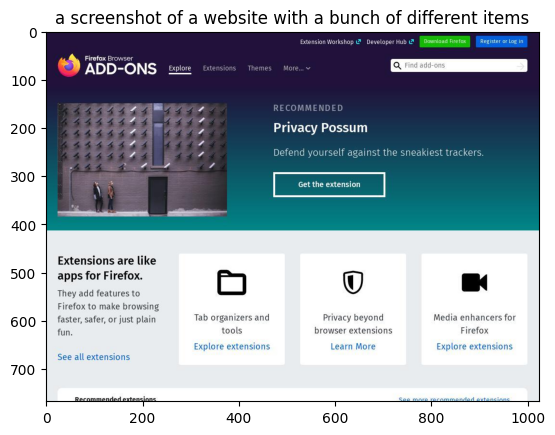

In [ ]:
import numpy as np
example = ds['test'][np.random.randint(0,100)]
image = example["image"]

model.eval()

inputs = processor(images=image, return_tensors="pt", max_patches=512).to(device)

flattened_patches = inputs.flattened_patches
attention_mask = inputs.attention_mask

generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

plt.imshow(image)
plt.title(generated_caption)
print("Generated caption:", generated_caption)

In [ ]:
# load image
!pip install anls
from anls import anls_score
!pip install evaluate
from evaluate import load
exact_match_metric = load("exact_match")
import matplotlib.pyplot as plt
%matplotlib inline

outputs = []
anls_scores = []

for idx in range(ds['test'].shape[0]):
  example = ds['test'][idx]
  image = example["image"]

  model.eval()

  inputs = processor(images=image, return_tensors="pt", max_patches=512).to(device)

  flattened_patches = inputs.flattened_patches
  attention_mask = inputs.attention_mask

  generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  outputs.append(generated_caption)
  anls_scores.append(anls_score(prediction=generated_caption, gold_labels=[example['text']], threshold=0.5))
  del inputs

Exact Match score:  0.024793388429752067
Average anls_score:  0.4222280019288088


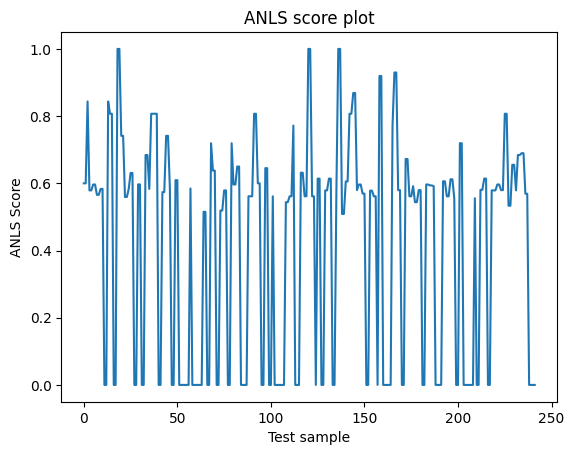

In [ ]:
em_scores = exact_match_metric.compute(predictions=outputs, references=ds['test']['text'])
print("Exact Match score: ", em_scores['exact_match'])
print("Average anls_score: ", np.average(anls_scores))
plt.plot(range(len(anls_scores)), anls_scores)
plt.xlabel("Test sample")
plt.ylabel("ANLS Score")
plt.title("ANLS score plot")
plt.show()